# Zonal Statistics


# Introduction to code
1. calculate zonal statistics for (indirect nutrient load/stream)WatershedPourPoints_LH.shp
2. Calculate Zonal statistics for (direct nutrient flux/coastal wetland corresponding watershed)wetland_connected_avg_inundation_NAD1983_Watershed
3. Subtract the values of flux that have overlap 

In [1]:
### Reqiured Imports###
import pandas, os
import arcpy
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Define the input paths

# Nutrient flux rasters
inDB = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\GIS_layer\Streamwatershed'
outDb = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\ZonalStats'
outFig = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\ZonalStats\Figures'
inBYRaster_TN = r"D:\Users\abolmaal\Arcgis\NutrietnFlux_Coastalwetlands\TN_Annual_delTotal_header_kgcellday.tif"
inBYRaster_TP = r"D:\Users\abolmaal\Arcgis\NutrietnFlux_Coastalwetlands\TP_Annual_delTotal_header_kgcellday.tif"

# Define the input feature classes
inPourpoint =  'WatershedPourPoints_NAD1983'
inWatershed = 'PointWaterdhed_LH_NAD1983'

# Define coastal watersheds
inCW = r'D:\Users\abolmaal\code\CoastalWatersheds\Erase_drainage'

inCoastalWatershed_low = r'D:\Users\abolmaal\code\CoastalWatersheds\Erase_lake\CoastalWatershed_low_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_high = r'D:\Users\abolmaal\code\CoastalWatersheds\Erase_lake\CoastalWatershed_high_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_avg = r'D:\Users\abolmaal\code\CoastalWatersheds\Erase_lake\CoastalWatershed_avg_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_surge = r'D:\Users\abolmaal\code\CoastalWatersheds\Erase_lake\CoastalWatershed_surge_erase_lakedrain_LakeHuron.shp'




# Out coastal feature
outTable = 'direct_coastal_N_P_wetland_loads'
outFeature = 'wetland_connected_avg_inundation_Albers'
#outFeature = 'wetlands_connected_high_inundation'
# Environment settings

arcpy.env.overwriteOutput = True
arcpy.env.workspace = inDB

tempZonal = 'temp_zonal_stats'

# Fields to calculate/ Direct delievery to Watersheds
fieldDirectTN = 'WetLoad_TN_kg2'
fieldDirectTP = 'WetLoad_TP_kg2'

## Direct delivery to Coastal Watersheds
fieldCoastalTN_avg = 'CoastLoad_TN_kg2_avg'
fieldCoastalTP_avg = 'CoastLoad_TP_kg2_avg'

fieldCoastalTN_low = 'CoastLoad_TN_kg2_low'
fieldCoastalTP_low = 'CoastLoad_TP_kg2_low'

fieldCoastalTN_high = 'CoastLoad_TN_kg2_high'
fieldCoastalTP_high = 'CoastLoad_TP_kg2_high'

fieldCoastalTN_surge = 'CoastLoad_TN_kg2_surge'
fieldCoastalTP_surge = 'CoastLoad_TP_kg2_surge'

#fieldCoastalTP = 'CoastLoad_TP_kg2'

fieldCoastalLimTN = 'CoastLoad_TN_lim_kg2'
fieldCoastalLimTP = 'CoastLoad_TP_lim_kg2'
fieldDirectRatio = 'WetLoad_TN_TP_ratio'
fieldCoastalRatio = 'CoastLoad_TN_TP_ratio'
fieldCoastalDirectRatioTN = 'Coast_Direct_ratio_TN'
fieldCoastalDirectRatioTP = 'Coast_Direct_ratio_TP'
############## Field Names ################
fieldpourpointTN = 'PourPoint_TN_kg'
fieldpourpointTP = 'PourPoint_TP_kg'


In [ ]:
# Bring in watershed 
dfWatershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inDB,inWatershed), ['Group_id', 'gridcode','Shape_Area']))

In [ ]:
dfWatershed

# 1- Estimate Zonal statistics for Stream Watreshed

In [ ]:
# 1- calculate the zonal statistics with arcpy for inWatershed using inBYRaster
inZonalTN_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, 'Group_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, 'Group_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inWatershed and inZonalTN_watershed as pandas dataframes
dfZonalTN_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_watershed,
                                                                  ['Group_id', 'AREA','SUM']))
# # rename SUM column to fieldDirectTN
dfZonalTN_watershed.rename(columns={'SUM':fieldDirectTN}, inplace=True)

dfZonalTP_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_watershed, 
                                                                   ['Group_id', 'AREA','SUM']))
# # rename SUM column to fieldDirectTP
dfZonalTP_watershed.rename(columns={'SUM':fieldDirectTP}, inplace=True)


In [ ]:
dfZonalTN_watershed

In [ ]:
#dfZonalTP_watershed
# add a line to calculate the ratio of TN/TP

dfZonalTP_watershed['WetLoad_TP_kg2'].plot(color='red', label='TP')
dfZonalTN_watershed['WetLoad_TN_kg2'].plot(color='blue', label='TN')
plt.xlabel('Watershed ID')
plt.ylabel('Nutrient Load (kgcell/day)')
plt.title('Direct Nutrient Load in Stream Watersheds')
plt.grid()
plt.legend()
plt.show()

In [ ]:
dfZonalTP_watershed

In [ ]:
dfWatershed

### 1-1 merge watershed with pour point

In [ ]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTP_watershed, left_on='Group_id', right_on='Group_id', how='inner')

In [ ]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTN_watershed, left_on='Group_id', right_on='Group_id', how='inner')
dfWatershed

In [ ]:
# plot dfWateshed['WetLoad_TN_gm2'] vs dfWateshed['WetLoad_TP_gm2']
plt.plot(dfWatershed['WetLoad_TP_kg2'], color='blue', label='TP')
plt.plot(dfWatershed['WetLoad_TN_kg2'], color='red', label='TN')
plt.legend()
plt.xlabel('Group_id')
plt.ylabel('WetLoad_TN/TP_kg2')
plt.title('WetLoad_TN_gm2 vs WetLoad_TP_gm2')
plt.show()

In [ ]:
# Save the dfWateshed to a csv file in the inDB directory with the name of Watresheds_total_N_P.csv
dfWatershed.to_csv(os.path.join(outDb, 'StreamWatresheds_total_N_P.csv'), index=False)

# 2- Zonal Statistics for coastal Wetlands watershed

Calculate the zonal statistics with arcpy for inCoastawateshed using inBYRaster_TN, and inBYRaster_TP


## 2-1  Zonal statistics for inCoastalWatershed for average inundation using inBYRaster_TN, inBYRaster_TP

In [3]:
#bring in the coastalwatreshed

dfCoastalWatershed_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_avg),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_low),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_high),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_surge),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

In [4]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_avg,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZononalTP_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_avg,
                                                                  ['coastal_id', 'AREA','SUM']))

In [5]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_avg[fieldCoastalTN_avg] = dfZonalTN_coastal_avg['SUM']/dfCoastalWatershed_avg['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZononalTP_coastal_avg[fieldCoastalTP_avg] = dfZononalTP_coastal_avg['SUM']/dfCoastalWatershed_avg['Shape_Area']

In [6]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTN_coastal_avg, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZononalTP_coastal_avg, left_on='coastal_id', right_on='coastal_id', how='inner')

## 2-2  Zonal statistics for inCoastalWatershed for high inundation using inBYRaster_TN, inBYRaster_TP


In [7]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_high,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZononalTP_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_high,
                                                                  ['coastal_id', 'AREA','SUM']))

In [8]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_high[fieldCoastalTN_high] = dfZonalTN_coastal_high['SUM']/dfCoastalWatershed_high['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZononalTP_coastal_high[fieldCoastalTP_high] = dfZononalTP_coastal_high['SUM']/dfCoastalWatershed_high['Shape_Area']

In [9]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTN_coastal_high, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZononalTP_coastal_high, left_on='coastal_id', right_on='coastal_id', how='inner')

## 2-3  Zonal statistics for inCoastalWatershed for low inundation using inBYRaster_TN, inBYRaster_TP


In [10]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_low,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZononalTP_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_low,
                                                                  ['coastal_id', 'AREA','SUM']))

In [11]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_low[fieldCoastalTN_low] = dfZonalTN_coastal_low['SUM']/dfCoastalWatershed_low['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZononalTP_coastal_low[fieldCoastalTP_low] = dfZononalTP_coastal_low['SUM']/dfCoastalWatershed_low['Shape_Area']

In [12]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTN_coastal_low, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZononalTP_coastal_low, left_on='coastal_id', right_on='coastal_id', how='inner')

## 2-4  Zonal statistics for inCoastalWatershed for Surge inundation using inBYRaster_TN, inBYRaster_TP


In [13]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_surge,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZononalTP_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_surge,
                                                                  ['coastal_id', 'AREA','SUM']))

In [14]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_surge[fieldCoastalTN_surge] = dfZonalTN_coastal_surge['SUM']/dfCoastalWatershed_surge['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZononalTP_coastal_surge[fieldCoastalTP_surge] = dfZononalTP_coastal_surge['SUM']/dfCoastalWatershed_surge['Shape_Area']

In [15]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_surge
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTN_coastal_surge, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZononalTP_coastal_surge, left_on='coastal_id', right_on='coastal_id', how='inner')

## 2-5 Save the dfCoastalWatershed as csv

In [16]:
# save the dfZonal_coastal to a csv file in the inDB directory with the name of CoastalWatershed_total_N_P.csv
dfCoastalWatershed_avg.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_avg.csv'), index=False)
dfCoastalWatershed_low.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_low.csv'), index=False)
dfCoastalWatershed_high.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_high.csv'), index=False)
dfCoastalWatershed_surge.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_surge.csv'), index=False)


# 3- Some plots

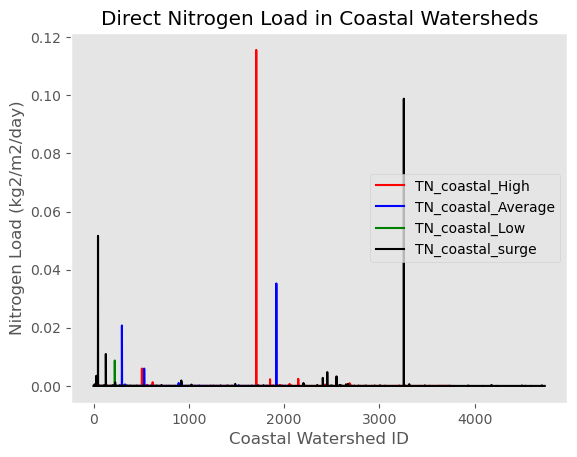

In [37]:
dfCoastalWatershed_high['CoastLoad_TN_kg2_high'].plot(color='red', label='TN_coastal_High')
dfCoastalWatershed_avg['CoastLoad_TN_kg2_avg'].plot(color='blue', label='TN_coastal_Average',zorder=2)
dfCoastalWatershed_low['CoastLoad_TN_kg2_low'].plot(color='green', label='TN_coastal_Low', zorder=1)
dfCoastalWatershed_surge['CoastLoad_TN_kg2_surge'].plot(color='black', label='TN_coastal_surge', zorder=3)
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Nitrogen Load (kg2/m2/day)')
plt.style.use('ggplot')

plt.title('Direct Nitrogen Load in Coastal Watersheds')
plt.grid()
plt.legend()
filename = 'Nitrogen_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

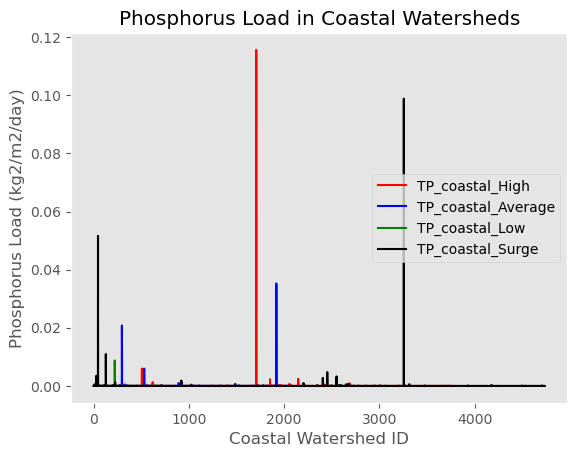

In [38]:
dfCoastalWatershed_high['CoastLoad_TP_kg2_high'].plot(color='red', label='TP_coastal_High')
dfCoastalWatershed_avg['CoastLoad_TP_kg2_avg'].plot(color='blue', label='TP_coastal_Average')
dfCoastalWatershed_low['CoastLoad_TP_kg2_low'].plot(color='green', label='TP_coastal_Low')
dfCoastalWatershed_surge['CoastLoad_TP_kg2_surge'].plot(color='black', label= 'TP_coastal_Surge')
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Phosphorus Load (kg2/m2/day)')
plt.title('Phosphorus Load in Coastal Watersheds')
plt.grid()
plt.legend()
plt.style.use('ggplot')

# save the figure in outFig path with the name Nutrient Load in Coastal Watersheds
filename = 'Nutrient_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

## boxplot

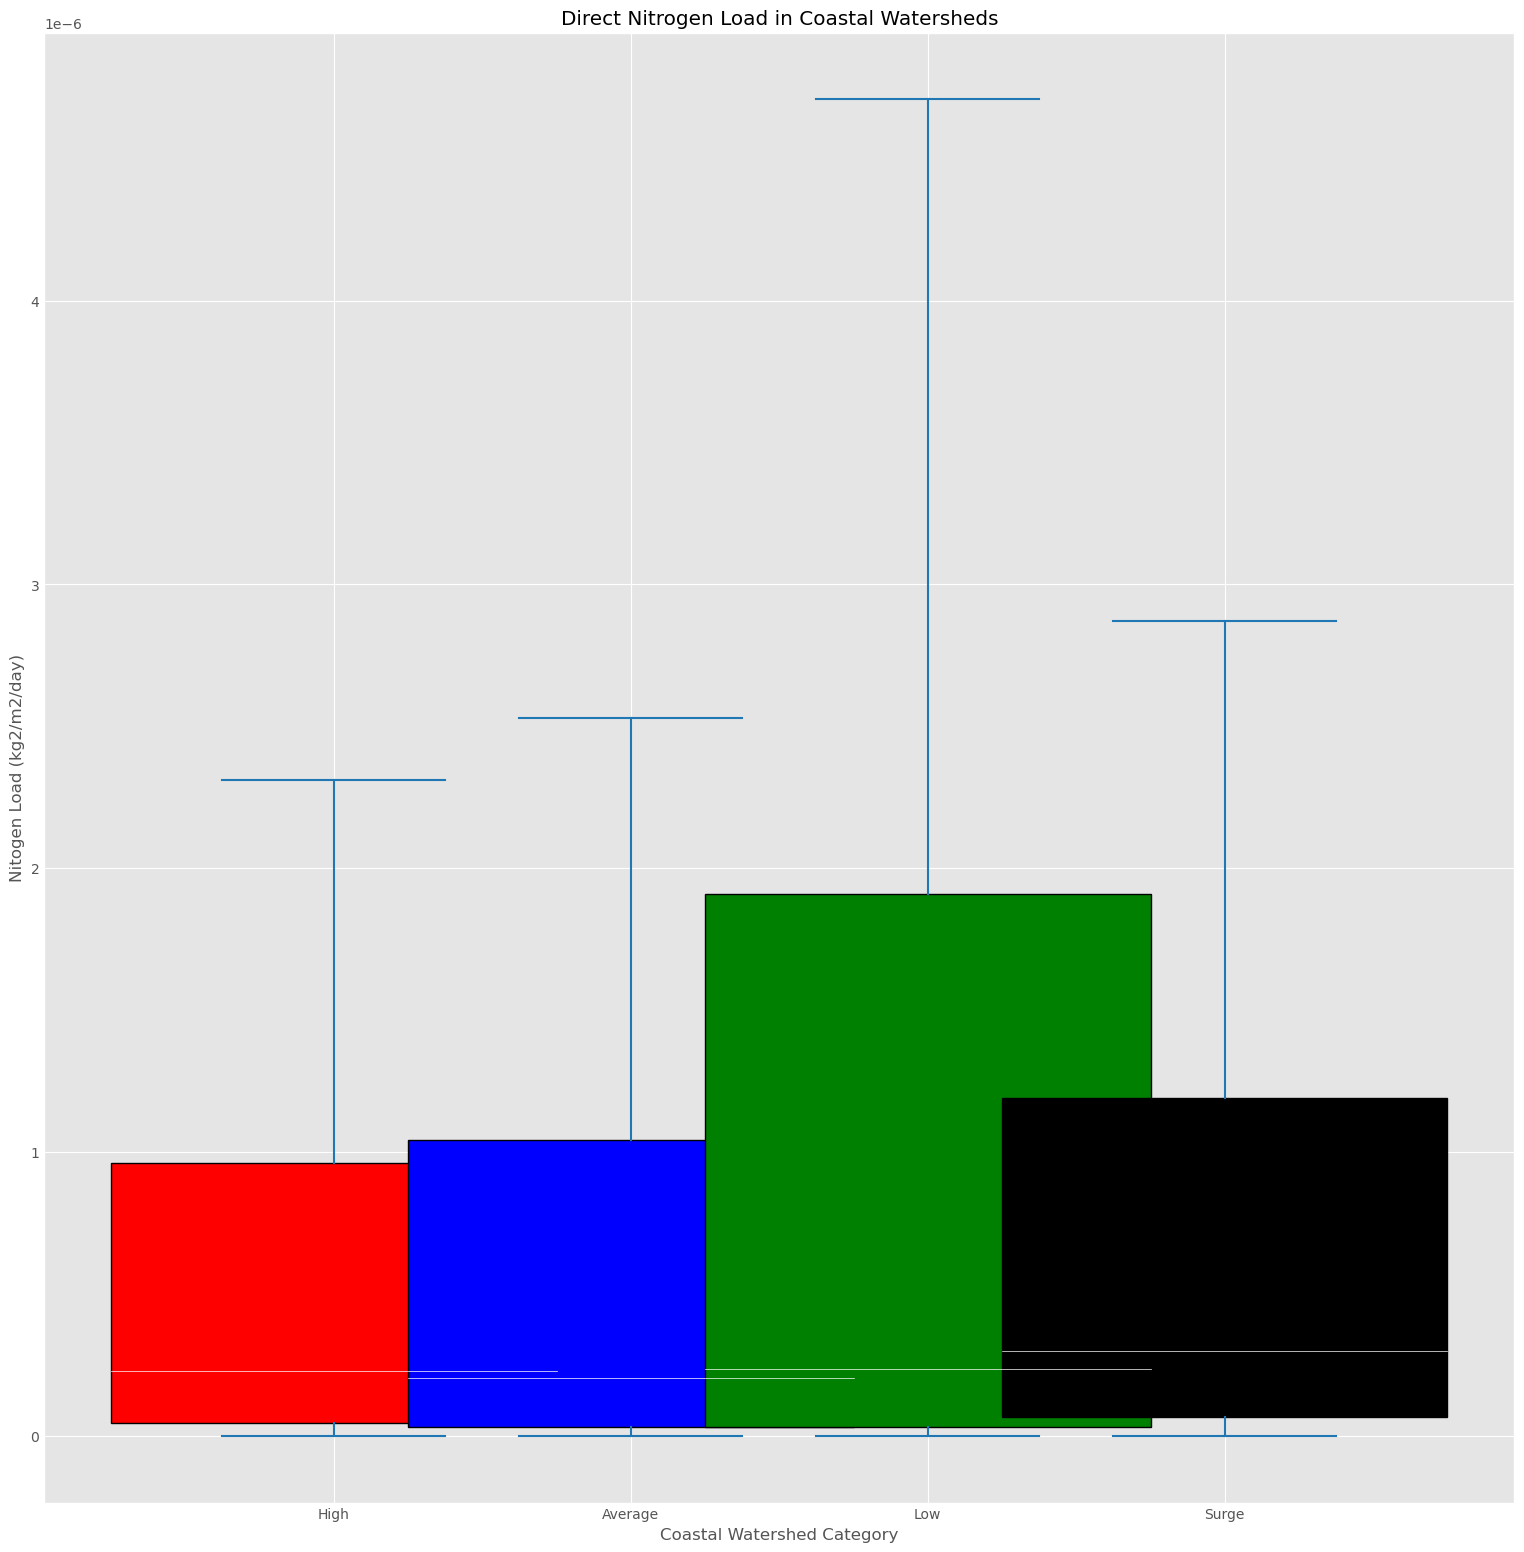

In [45]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data_N = [
    dfCoastalWatershed_high['CoastLoad_TN_kg2_high'],
    dfCoastalWatershed_avg['CoastLoad_TN_kg2_avg'],
    dfCoastalWatershed_low['CoastLoad_TN_kg2_low'],
    dfCoastalWatershed_surge['CoastLoad_TN_kg2_surge']
]
# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Create the box plot
box = ax.boxplot(data_N, labels=['High', 'Average', 'Low', 'Surge'], positions=[1, 2, 3, 4], widths=1.5, patch_artist=True,
                 showmeans=False, showfliers=False,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5})

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Nitogen Load (kg2/m2/day)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')

filename = 'Nitrogen_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)

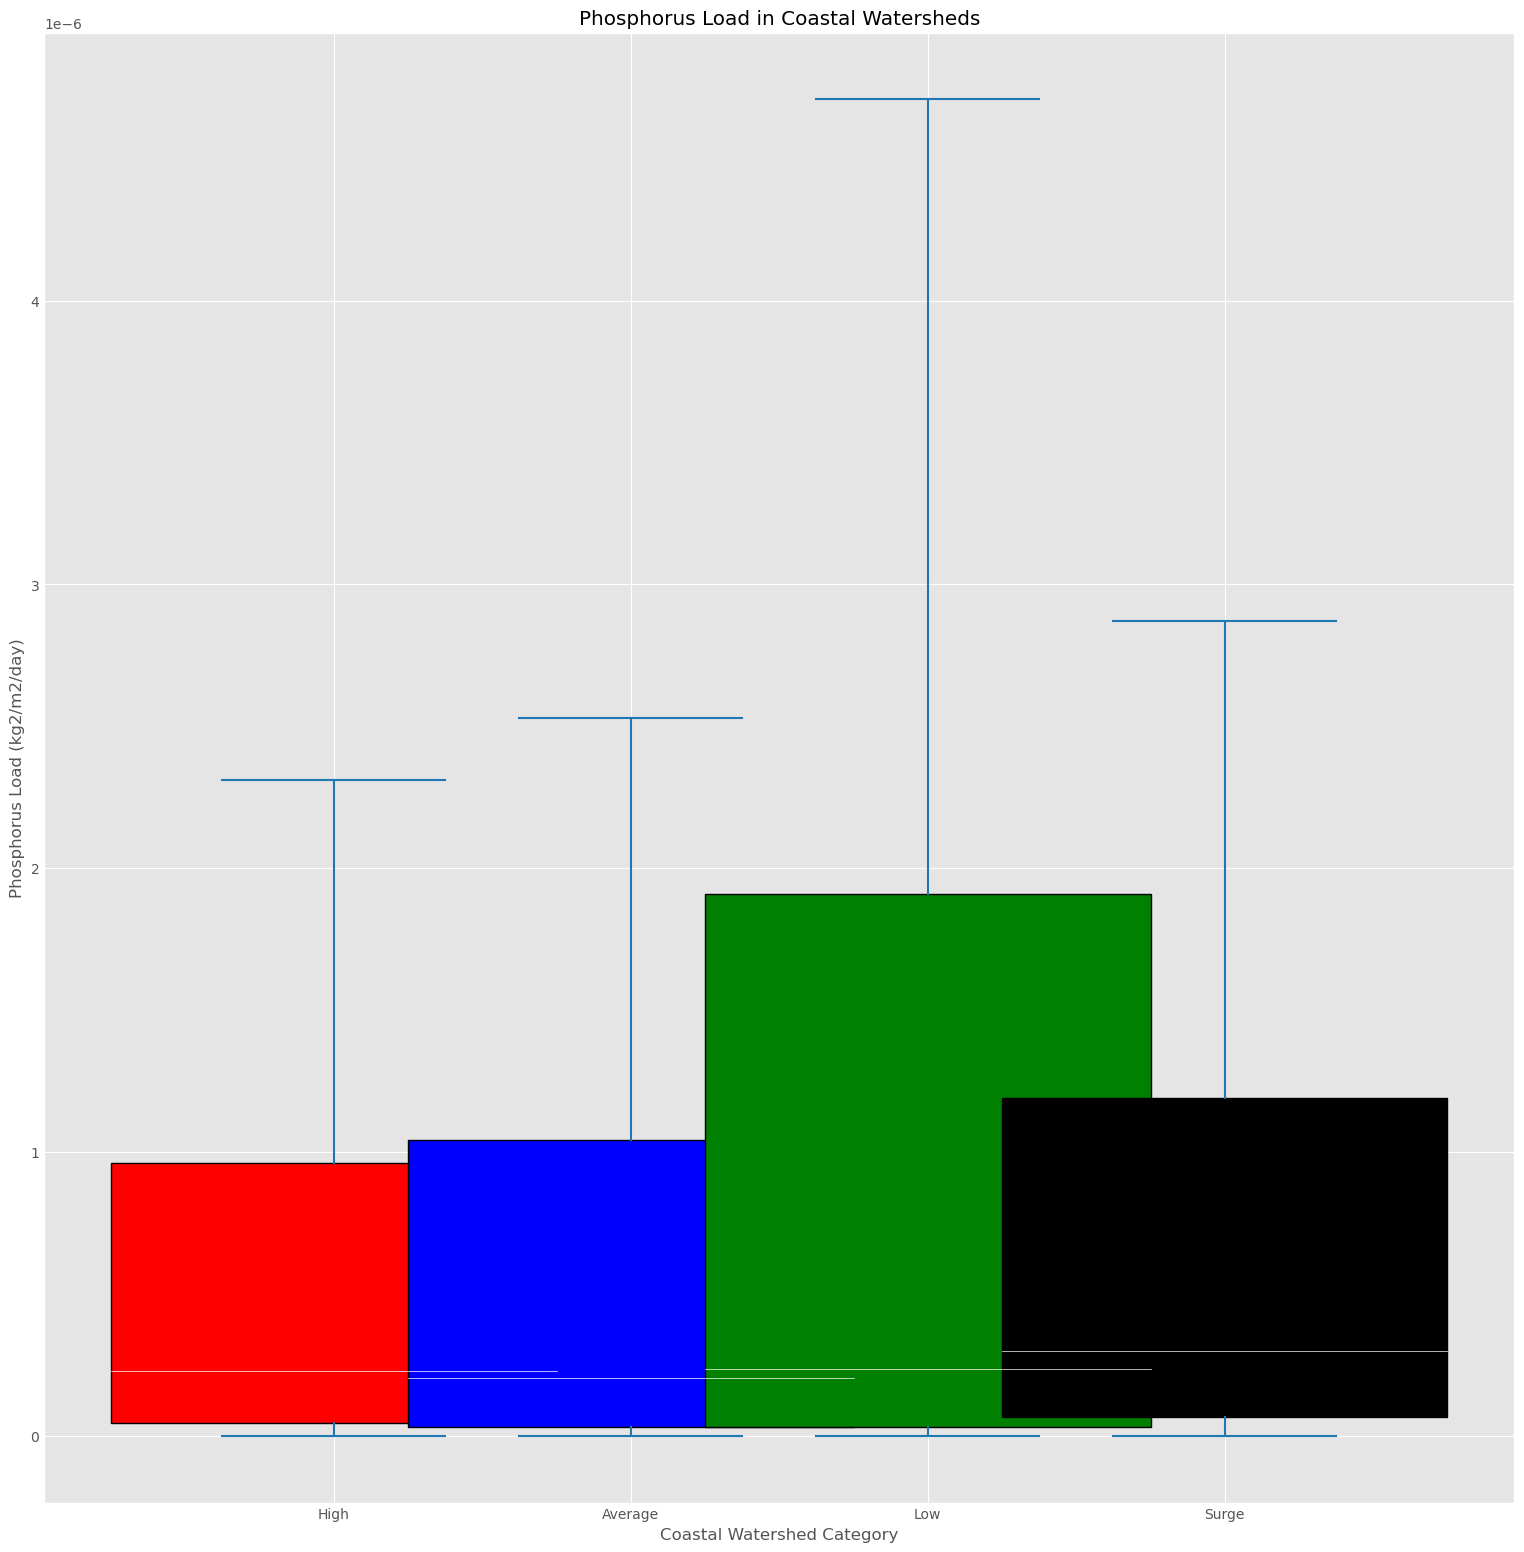

In [44]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data = [
    dfCoastalWatershed_high['CoastLoad_TP_kg2_high'],
    dfCoastalWatershed_avg['CoastLoad_TP_kg2_avg'],
    dfCoastalWatershed_low['CoastLoad_TP_kg2_low'],
    dfCoastalWatershed_surge['CoastLoad_TP_kg2_surge']
]
# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Create the box plot
box = ax.boxplot(data, labels=['High', 'Average', 'Low', 'Surge'], positions=[1, 2, 3, 4], widths=1.5, patch_artist=True,
                 showmeans=False, showfliers=False,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5})

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Phosphorus Load (kg2/m2/day)')
plt.title('Phosphorus Load in Coastal Watersheds')

filename = 'Phosphorus_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
